<a href="https://colab.research.google.com/github/SalomonMalka/Black-and-white-image-colorization/blob/main/Colorization_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization with U-Net

# 1 - Imports and data loading

The following downloads the libraries fastai - for importing the image dataset (COCO dataset) and piqa - for testing loss functions 

In [1]:
!pip install fastai==2.4
!pip install piqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 27.5 MB/s eta 0:00:00
     ━━━━━━

In [2]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from scipy.stats import wasserstein_distance

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import piqa
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### 1.1 - Imports in colab

The following will download about 20,000 images from COCO dataset.

In [3]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [4]:
if use_colab == True:
    path = coco_path
else:
    path = "/coco_dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 5_000, replace=False) # choosing 10_000 images randomly
rand_idxs = np.random.permutation(5_000)
train_idxs = rand_idxs[:3008] # choosing the first 8000 as training set
val_idxs = rand_idxs[3008:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(f"Size of train and validation set: {len(train_paths)}, {len(val_paths)}")

Size of train and validation set: 3008, 1992


Print some images from the train dataset

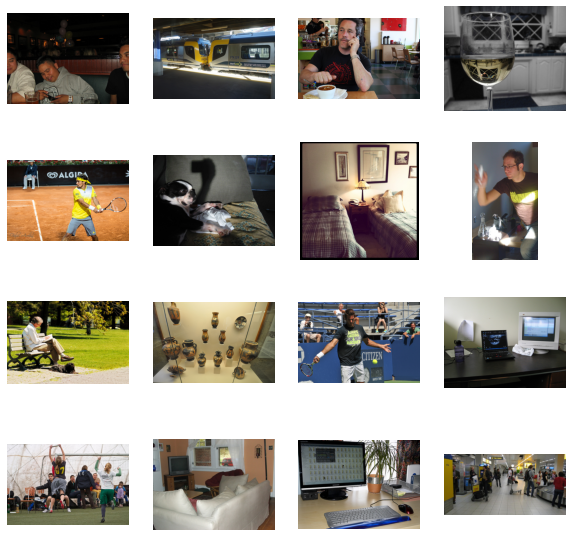

In [5]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2 - Making Datasets and DataLoaders

We separate the data into **L\*a\*b** channels. The **L** channel will be the **black-and-white** images and the **a*b** channels we aim to **predict**.

In [6]:
SIZE = 128
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        color = transforms.ToTensor()(img)
        
        # split the data into gray version (L channel of the Lab space)
        # and color version (original image)
        return {'L': L, 'color': color}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): 
  # A handy function to make our dataloaders
  dataset = ColorizationDataset(**kwargs)
  dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                          pin_memory=pin_memory)
  return dataloader

Create train and validation dataloader

In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

# print the dimension of the data
data = next(iter(train_dl))
Ls, colors_ = data['L'], data['color']
print("L channel image shape :", Ls.shape)
print("color channel image shape :", colors_.shape)
print(f"Lenght of train and validation set batches: {len(train_dl)}, {len(val_dl)}")

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L channel image shape : torch.Size([16, 1, 128, 128])
color channel image shape : torch.Size([16, 3, 128, 128])
Lenght of train and validation set batches: 188, 125


Plot the gray and color version of an image from the data. 

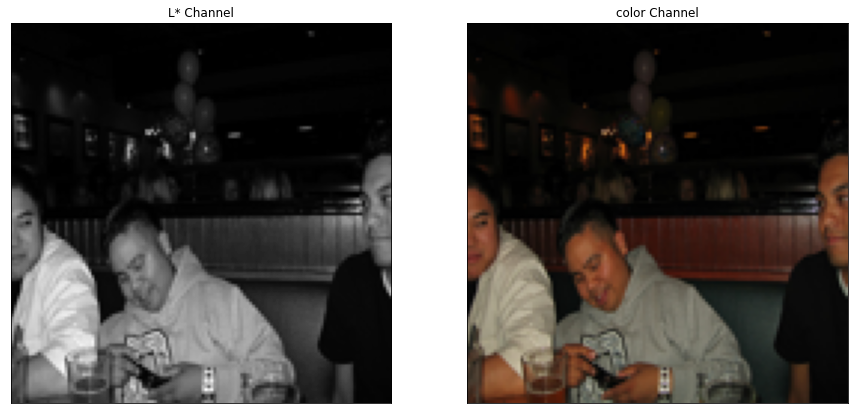

In [8]:
import matplotlib.colors as colors

data = next(iter(train_dl))
data['L'].shape

L_channel = data['L'][0][0]
color_channel = data['color'][0]

fig, axes = plt.subplots(1, 2, figsize = (15,15))
axes[0].imshow(L_channel, cmap = 'gray')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("L* Channel")

axes[1].imshow(color_channel.permute(1,2,0))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("color Channel")

plt.savefig("Lab_channel_example.jpg")
plt.show()


# 2 - Create the model

### 2.1 - Utility functions

In [9]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

save_rep = "saved_results"
def visualize_images_RGB(L,original, preds, save = False, title = ''):
  original_image = original.cpu()
  predicted_image = preds.cpu()

  # plot the images
  fig = plt.figure(figsize=(15, 8))
  for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(predicted_image[i].permute(1,2,0))
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(original_image[i].permute(1,2,0))
    ax.axis("off")
  plt.show()
  if save:
    plt.savefig(save_rep+title+'.jpg')

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

### 2.1 - Main Model 

In [10]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [11]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

The final model is:

In [12]:
print(Unet(input_c=1, output_c=3, n_down=4, num_filters=32))

Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

### 2.2 Training the model

  0%|          | 0/188 [00:00<?, ?it/s]

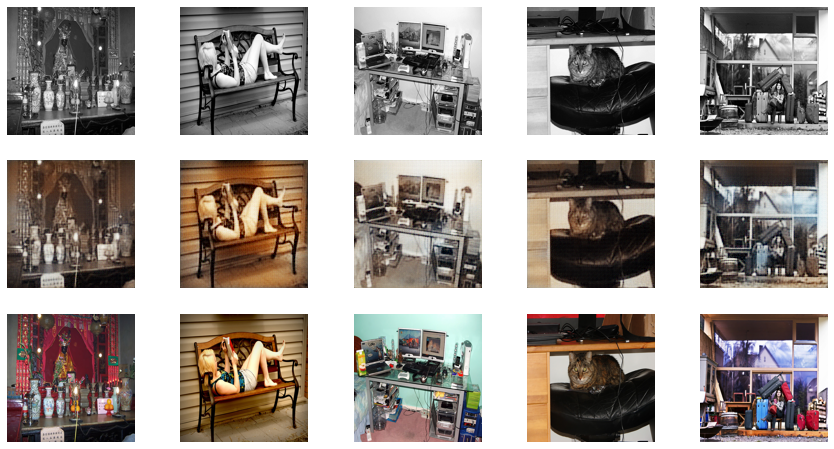

L1 Loss: 0.00000


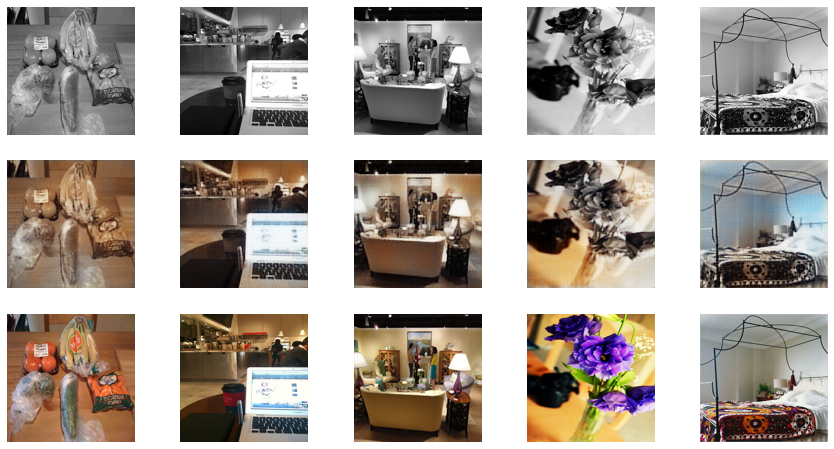

Epoch 1/10
Loss: 0.01521


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

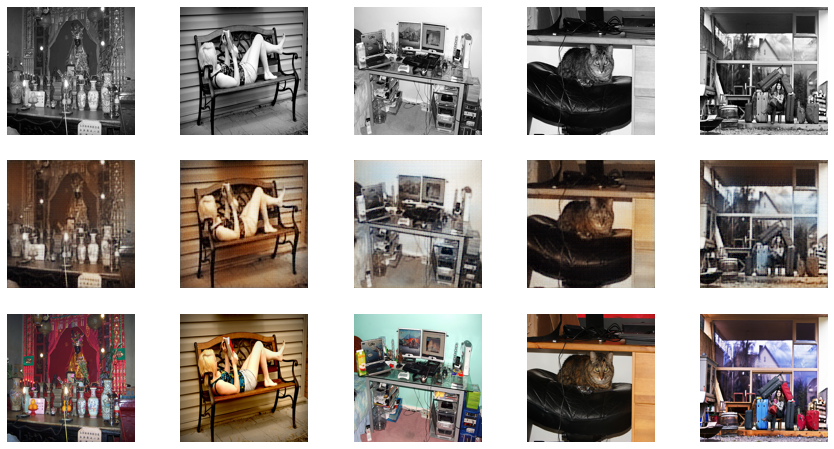

L1 Loss: 0.00000


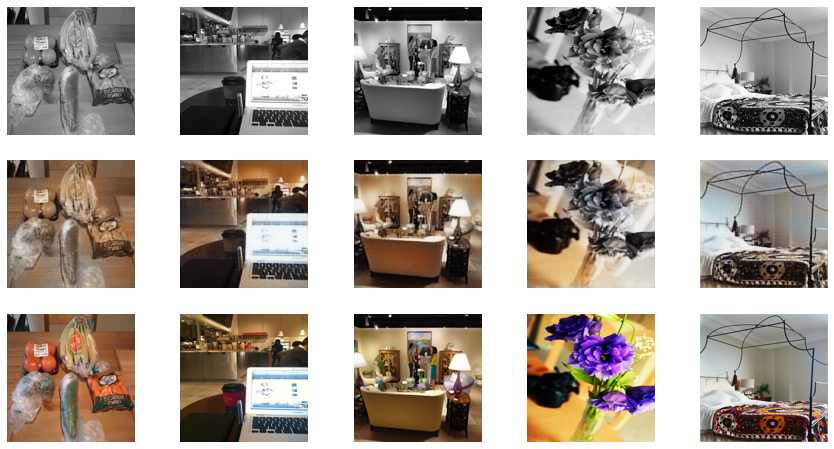

Epoch 2/10
Loss: 0.01497


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

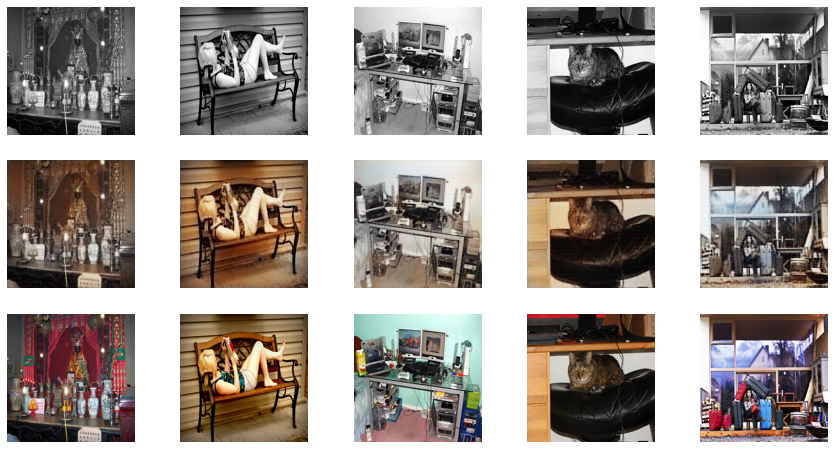

L1 Loss: 0.00000


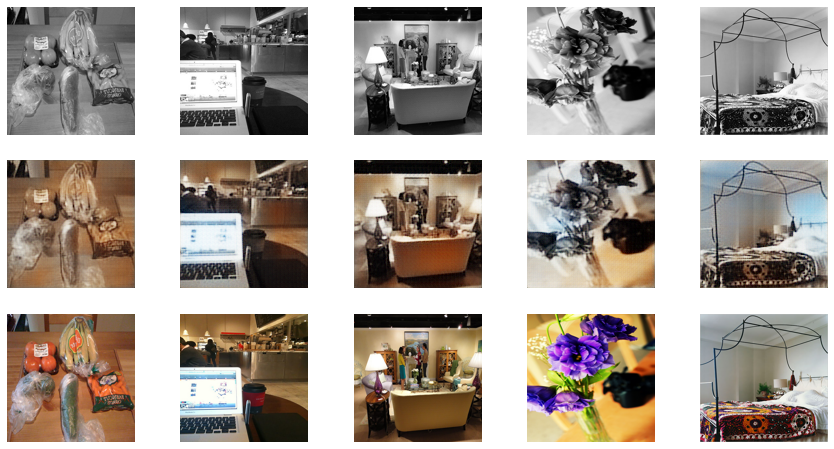

Epoch 3/10
Loss: 0.01476


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

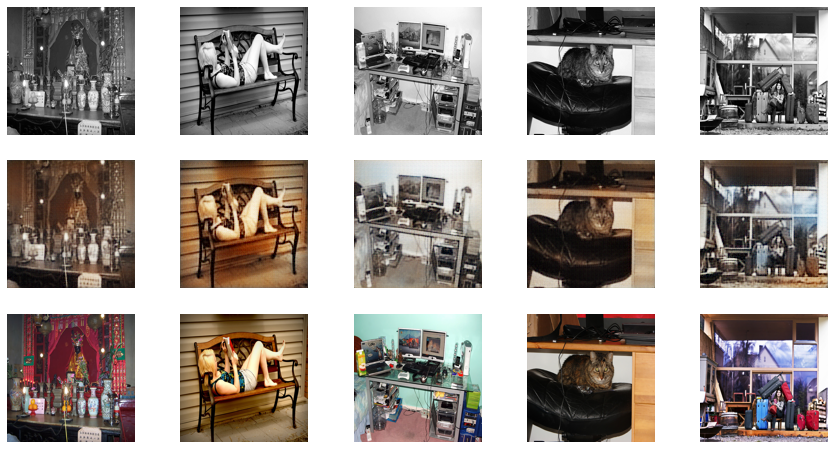

L1 Loss: 0.00000


In [ ]:
L1_distance_array = []
L1_val_array = []
MSE_distance_array = []

L2param = 200.
RegulParam = 0.01

def train_model(model, train_dl, opt, criterion, epochs, val_dl, visualize_every = 200):
  for e in range(epochs):
    loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    counter = 0
    for data in tqdm(train_dl):
      L, color = data['L'].to(device), data['color'].to(device)
      preds = model(L)

      # visualize predicted images and loss every visualize_every cycles
      if counter % visualize_every == 0:
        visualize_images_RGB(L.detach(),color.detach(),preds.detach(), save = False)
        print(f"L1 Loss: {loss_meter.avg:.5f}")
      counter += 1
      
      # create an brownish image to apply when training the MSE engineered loss
      mean_R = torch.mean(preds[:,0].reshape(16,1,SIZE,SIZE), keepdim = True, dim = (2,3))
      mean_G = torch.mean(preds[:,1].reshape(16,1,SIZE,SIZE), keepdim = True, dim = (2,3))
      mean_B = torch.mean(preds[:,2].reshape(16,1,SIZE,SIZE), keepdim = True, dim = (2,3))

      color_grey = torch.cat([torch.mul(L,mean_R),
                              torch.mul(L,mean_G),
                              torch.mul(L,mean_B)], dim=1)  / torch.mean(L)

      # MSE engineered loss
      loss = criterion(preds, color) + RegulParam * torch.min(criterion(preds, color_grey),torch.tensor(1))

      # Save MSE and L1 history
      L1_loss = nn.L1Loss()(preds.detach(), color.detach())
      MSE_loss = nn.MSELoss()(preds.detach(), color.detach())
      L1_distance_array.append(L1_loss.item())
      MSE_distance_array.append(MSE_loss.item())

      opt.zero_grad()
      loss.backward()
      opt.step()
      loss_meter.update(loss.item(), L.size(0))

    visualize_images_RGB(L.detach(),color.detach(),preds.detach(), save = True, title = str(e))
    print(f"Epoch {e + 1}/{epochs}")
    print(f"Loss: {loss_meter.avg:.5f}")

torch.cuda.empty_cache()
# initialize the model
unet = init_model(Unet(input_c=1, output_c=3, n_down=4, num_filters=32), device)

# load params to the model
unet.load_state_dict(torch.load("unet_saved_params.pt", map_location=device))

beta1 = 0.5
beta2 = 0.999
opt = optim.Adam(unet.parameters(), lr=1e-4, betas = (beta1,beta2))

# try your own losses
#criterion = piqa.LPIPS(network='vgg').to(device)
#criterion = VGGPerceptualLoss().to(device)
criterion = nn.MSELoss()

num_epochs = 10
train_model(unet, train_dl, opt, criterion, num_epochs, val_dl)

# save model params for additional training
torch.save(unet.state_dict(), "unet_saved_params.pt")

The following shows the L1 and MSE for the training:

In [ ]:
plt.figure()
plt.plot(L1_distance_array)
plt.plot(MSE_distance_array)